In [409]:
import numpy as np
import pandas as pd
import pyarrow

from pandas_profiling import ProfileReport

from ipyleaflet import * 
from ipyleaflet import (
    Map, TileLayer, SplitMapControl, Marker, basemaps, MarkerCluster, Choropleth
)

import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import holidays
from datetime import timedelta

us_ca_holidays = holidays.UnitedStates(state="CA", years=range(2010, 2025))


In [524]:
#df = pd.read_parquet('./data/safety-SanFrancisco.parquet') 
df = pd.read_parquet('./data/safety-SanFrancisco-2.parquet') 
df = df.drop(['dataType', 'extendedProperties'], axis=1)
for col in ["dataSubtype", "category", "subcategory"]:
    df[col] = pd.Categorical(df[col])
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%Y%m%d %H:%M:%S')

df = pd.DataFrame.drop_duplicates(df)

top_categories = pd.Series(['Street and Sidewalk Cleaning'
                            #'Potentially Life-Threatening'
                            #,'Graffiti'
                            #,'Encampments'
                            #,'Street and Sidewalk Cleaning'
                            #,'Non Life-threatening'
                           ])
df = df[df['category'].isin(top_categories)]

mask = (
    (df["dateTime"] >= pd.to_datetime("2019-01-20")) & (df["dateTime"] < pd.to_datetime("2020-01-21"))
)

#df = df[mask]
#df.index=df['dateTime']

#df['DayOfWeek']=df["dateTime"].dt.day_name()
df['DayOfWeek']=df["dateTime"].dt.dayofweek
df['Hour']=df["dateTime"].dt.hour
df['Month']=df["dateTime"].dt.month
df['Day']=df["dateTime"].dt.day
df['Year']=df["dateTime"].dt.year
df['DayOfYear']=df["dateTime"].dt.dayofyear

holiday_eve = []
for date in us_ca_holidays.keys():
    holiday_eve.append(date - timedelta(days=1))
    
df['is_holiday']=df["dateTime"].dt.date.isin(holiday_eve)
df.head()

,requestId,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source,neighborhood,DayOfWeek,Hour,Month,Day,Year,DayOfYear,is_holiday
1,2,311_All,2018-07-08 15:00:27,Street and Sidewalk Cleaning,Bulky Items,Closed,"1536 SACRAMENTO ST, SAN FRANCISCO, CA, 94109",37.791887,-122.418188,Mobile/Open311,Nob Hill,6,15,7,8,2018,189,False
5,12,311_All,2020-04-10 12:45:00,Street and Sidewalk Cleaning,Medical Waste,Closed,"4 TURK ST, SAN FRANCISCO, CA, 94102",37.783520,-122.409487,Web,Tenderloin,4,12,4,10,2020,101,False
10,30,311_All,2019-01-02 17:35:00,Street and Sidewalk Cleaning,City_garbage_can_overflowing,Closed,Intersection of BEACH ST and HYDE ST,37.806656,-122.420563,Phone,Nob Hill,2,17,1,2,2019,2,False
15,43,311_All,2019-07-23 12:04:00,Street and Sidewalk Cleaning,General Cleaning,Closed,"180 PENNSYLVANIA AVE, SAN FRANCISCO, CA, 94107",37.764300,-122.393714,Mobile/Open311,South Beach,1,12,7,23,2019,204,False
22,57,311_All,2018-06-27 10:55:00,Street and Sidewalk Cleaning,General Cleaning,Closed,"850 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",37.788984,-122.415220,Mobile/Open311,Nob Hill,2,10,6,27,2018,178,False


In [490]:
df_weather = pd.read_parquet("./data/weather-data-SF-Nyc-Seattle-2015-2020.parquet")
df_weather["date"] = pd.to_datetime(df_weather["date"], format="%Y%m%d")

df_weather = df_weather[df_weather["station"] == "USW00023234"]
df_weather.head()
df_weather.shape
#profile = ProfileReport(df_weather, title="Pandas Profiling Report")
#profile



(12641, 4)

In [491]:
df_weather = df_weather.set_index(["date", "field"])["value"].unstack(-1)
df_weather = df_weather.fillna(method="ffill").fillna(method="bfill")

df_weather.head()


field,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,WSF2
date,,,,,,,
2015-01-01,38.0,0.0,0.0,97.0,128.0,44.0,89.0
2015-01-02,7.0,0.0,0.0,77.0,111.0,33.0,31.0
2015-01-03,7.0,0.0,0.0,77.0,122.0,33.0,31.0
2015-01-04,9.0,0.0,0.0,86.0,128.0,50.0,63.0
2015-01-05,11.0,0.0,0.0,98.0,150.0,61.0,31.0


In [525]:
df["date"] = df["dateTime"].dt.date

df_weather["date_merge"] = df_weather.index.date
    
df2 = df.merge(df_weather, left_on="date", right_on="date_merge", how="left")
df2.shape

del df2["date_merge"]


In [526]:
df = df2

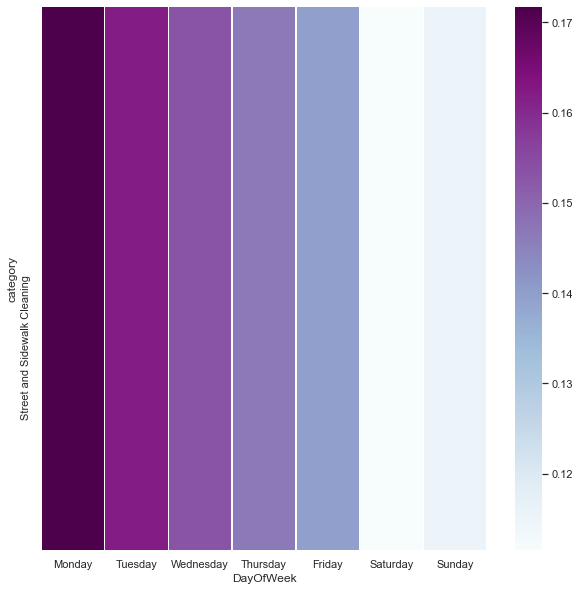

In [377]:
cat_per_week_common = pd.crosstab(df['category'], df['DayOfWeek']) 
cat_per_week_common = cat_per_week_common.div(cat_per_week_common.sum(axis=1), axis=0)

# Rearrange columns
cat_per_week_common = cat_per_week_common[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']]

# Transform into a heat map
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cat_per_week_common, cmap="BuPu", linewidths=.5)




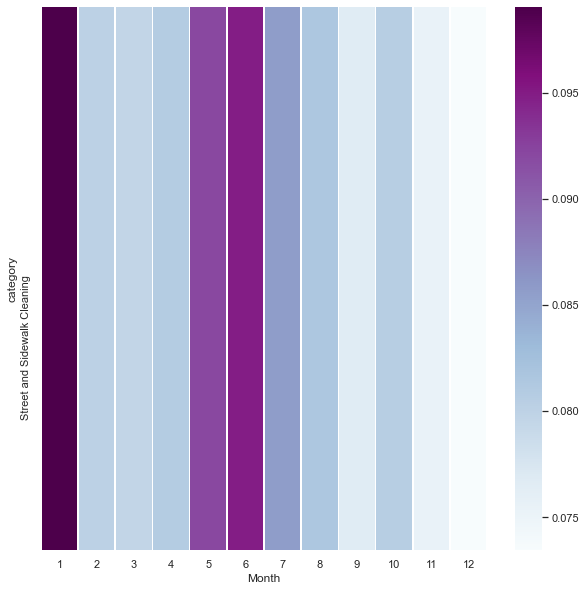

In [379]:
cat_per_week_common = pd.crosstab(df['category'], df['Month']) 
cat_per_week_common = cat_per_week_common.div(cat_per_week_common.sum(axis=1), axis=0)

# Rearrange columns
#cat_per_week_common = cat_per_week_common[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']]

# Transform into a heat map
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cat_per_week_common, cmap="BuPu", linewidths=.5)

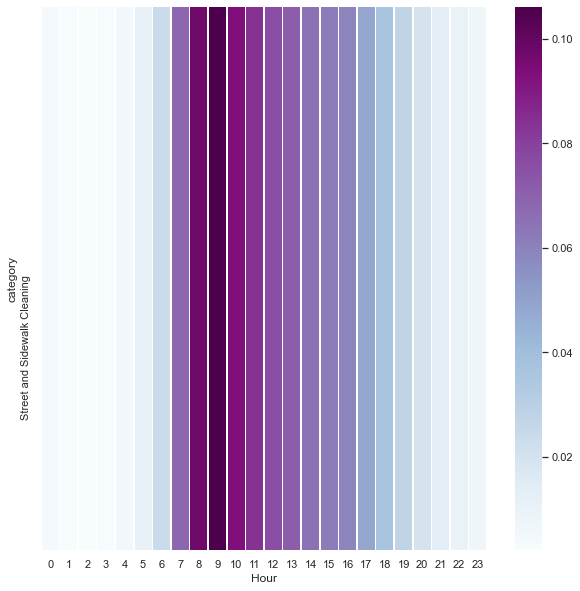

In [380]:
cat_per_week_common = pd.crosstab(df['category'], df['Hour']) 
cat_per_week_common = cat_per_week_common.div(cat_per_week_common.sum(axis=1), axis=0)

# Rearrange columns
#cat_per_week_common = cat_per_week_common[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']]

# Transform into a heat map
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cat_per_week_common, cmap="BuPu", linewidths=.5)

<AxesSubplot:xlabel='dateTime'>

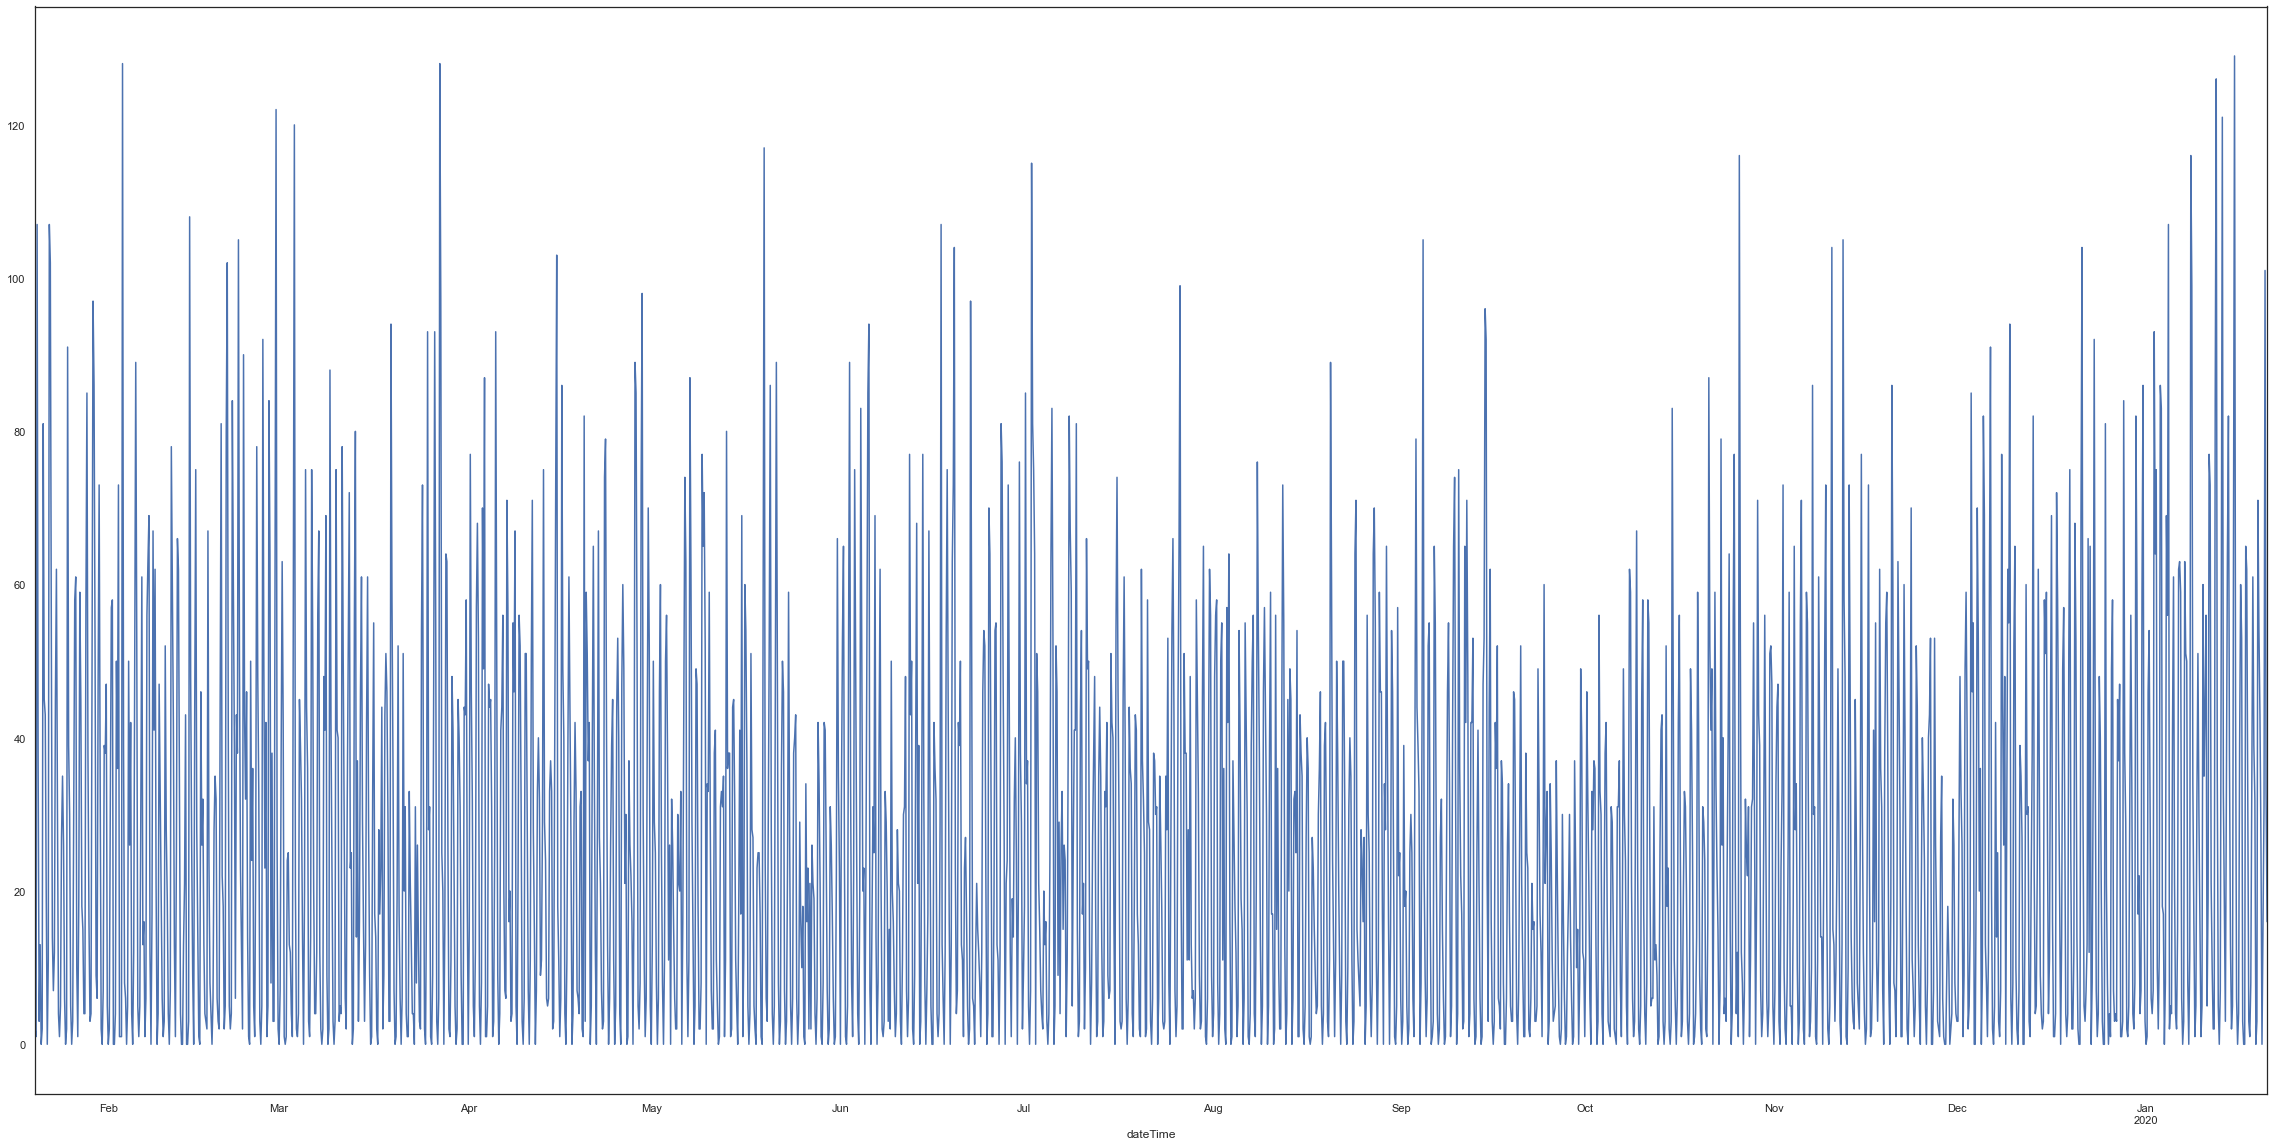

In [128]:
mask = (
    (df["dateTime"] >= pd.to_datetime("2019-01-20")) & (df["dateTime"] < pd.to_datetime("2020-01-21"))
)

df = df[mask]

fig = plt.figure(figsize=(40,20))

df[df['category']=='Graffiti'].groupby(pd.Grouper(key="dateTime", freq="4H"))["requestId"].count().plot()


In [527]:
df.head()

,requestId,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source,...,DayOfYear,is_holiday,date,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,WSF2
0,2,311_All,2018-07-08 15:00:27,Street and Sidewalk Cleaning,Bulky Items,Closed,"1536 SACRAMENTO ST, SAN FRANCISCO, CA, 94109",37.791887,-122.418188,Mobile/Open311,...,189,False,2018-07-08,73.0,0.0,0.0,198.0,206.0,122.0,139.0
1,12,311_All,2020-04-10 12:45:00,Street and Sidewalk Cleaning,Medical Waste,Closed,"4 TURK ST, SAN FRANCISCO, CA, 94102",37.783520,-122.409487,Web,...,101,False,2020-04-10,59.0,0.0,0.0,145.0,172.0,117.0,103.0
2,30,311_All,2019-01-02 17:35:00,Street and Sidewalk Cleaning,City_garbage_can_overflowing,Closed,Intersection of BEACH ST and HYDE ST,37.806656,-122.420563,Phone,...,2,False,2019-01-02,7.0,0.0,0.0,79.0,122.0,33.0,31.0
3,43,311_All,2019-07-23 12:04:00,Street and Sidewalk Cleaning,General Cleaning,Closed,"180 PENNSYLVANIA AVE, SAN FRANCISCO, CA, 94107",37.764300,-122.393714,Mobile/Open311,...,204,False,2019-07-23,60.0,0.0,0.0,169.0,217.0,144.0,125.0
4,57,311_All,2018-06-27 10:55:00,Street and Sidewalk Cleaning,General Cleaning,Closed,"850 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",37.788984,-122.415220,Mobile/Open311,...,178,False,2018-06-27,47.0,0.0,0.0,179.0,206.0,122.0,112.0


In [528]:
#df = df.drop(['requestId', 'dataSubtype', 'source', 'latitude', 'longitude', 'address', 'status', 'subcategory'], axis=1)

#df = df.drop(['Month', 'Hour', 'Day', 'DayOfWeek', 'requestId', 'dataSubtype', 'source', 'latitude', 'longitude', 'address', 'status', 'subcategory'], axis=1)
#df.index=df['dateTime']
#df.drop(['dateTime'])

top_neighborhood = pd.Series(['Mission'
                            ,'SoMa'
                            ,'Tenderloin'
                            ,'Nob Hill'
                            ,'Ingleside'
                           ])

df = df[df['neighborhood'].isin(top_neighborhood)]

agg_func = {'neighborhood': ['count']}

#agg = df.groupby([pd.Grouper(key='dateTime', freq='4h'), 'neighborhood']).agg(agg_func).reset_index()

agg = df.groupby([pd.Grouper(key='dateTime', freq='4h'), 
                  'neighborhood', 'Year', 
                  'Month', 'Hour', 'Day', 
                  'DayOfWeek', 'DayOfYear', 
                  'AWND','PRCP','SNWD','TAVG',
                  'TMAX','TMIN','WSF2'])["requestId"].count().reset_index().rename(columns={"requestId": "count"})
  
    
#df.groupby(["dateTime", "neighborhood"]).agg(agg_func).head()
#agg.reset_index()
agg.sort_values("dateTime")


,dateTime,neighborhood,Year,Month,Hour,Day,DayOfWeek,DayOfYear,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,WSF2,count
0,2016-01-01 00:00:00,Nob Hill,2016,1,1,1,4,1,39.0,0.0,0.0,70.0,94.0,28.0,76.0,1
1,2016-01-01 04:00:00,Mission,2016,1,4,1,4,1,39.0,0.0,0.0,70.0,94.0,28.0,76.0,2
13,2016-01-01 08:00:00,Tenderloin,2016,1,11,1,4,1,39.0,0.0,0.0,70.0,94.0,28.0,76.0,1
12,2016-01-01 08:00:00,Tenderloin,2016,1,9,1,4,1,39.0,0.0,0.0,70.0,94.0,28.0,76.0,1
11,2016-01-01 08:00:00,SoMa,2016,1,11,1,4,1,39.0,0.0,0.0,70.0,94.0,28.0,76.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117653,2020-06-05 16:00:00,Nob Hill,2020,6,18,5,4,157,51.0,0.0,0.0,171.0,317.0,144.0,125.0,4
117663,2020-06-05 20:00:00,Mission,2020,6,20,5,4,157,51.0,0.0,0.0,171.0,317.0,144.0,125.0,2
117664,2020-06-05 20:00:00,Mission,2020,6,23,5,4,157,51.0,0.0,0.0,171.0,317.0,144.0,125.0,1
117662,2020-06-05 20:00:00,Ingleside,2020,6,22,5,4,157,51.0,0.0,0.0,171.0,317.0,144.0,125.0,1


In [529]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
import sklearn
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    agg.sort_values("dateTime"), test_size=0.05, shuffle=False
)



In [530]:
df_train.tail()

,dateTime,neighborhood,Year,Month,Hour,Day,DayOfWeek,DayOfYear,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,WSF2,count
111787,2020-03-20 12:00:00,Nob Hill,2020,3,15,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,3
111794,2020-03-20 12:00:00,Tenderloin,2020,3,14,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,2
111793,2020-03-20 12:00:00,Tenderloin,2020,3,13,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,2
111792,2020-03-20 12:00:00,Tenderloin,2020,3,12,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,3
111791,2020-03-20 12:00:00,SoMa,2020,3,15,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,1


In [531]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
import sklearn
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder

column_transformer = ColumnTransformer(
    [
        (
            "cat", OrdinalEncoder(), ["neighborhood", "Year"],
        ),
        (
            "passthrough",
            "passthrough",
            ["Month", "Day", "DayOfWeek", "Hour", "DayOfYear"],
        ),
        (
            "numeric",
            StandardScaler(),
            ["AWND", "PRCP", "TAVG", "TMAX", "TMIN", "WSF2"],
        ),
    ]
)

pipe = make_pipeline( column_transformer)
X_train = pipe.fit_transform(df_train)
X_test = pipe.transform(df_test)

est = Ridge().fit(X_train, df_train["count"])

In [502]:
from sklearn.metrics import classification_report

df_test["predicted"] = est.predict(X_test)
df_test.head()

y_pred = est.predict(X_test)


In [395]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [532]:
df_test["predicted"] = est.predict(X_test)
df_test.head()

,dateTime,neighborhood,Year,Month,Hour,Day,DayOfWeek,DayOfYear,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,WSF2,count,predicted
111790,2020-03-20 12:00:00,SoMa,2020,3,14,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,1,3.951496
111789,2020-03-20 12:00:00,SoMa,2020,3,13,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,2,4.062594
111788,2020-03-20 12:00:00,SoMa,2020,3,12,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,1,4.173693
111795,2020-03-20 12:00:00,Tenderloin,2020,3,15,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,2,3.818224
111785,2020-03-20 12:00:00,Nob Hill,2020,3,13,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,3,4.084767


In [537]:
from sklearn.experimental import enable_hist_gradient_boosting 

from sklearn.ensemble import HistGradientBoostingRegressor

est2 = HistGradientBoostingRegressor().fit(X_train, df_train["count"],)

In [538]:
df_test["predicted"] = est2.predict(X_test)
df_test.head()

,dateTime,neighborhood,Year,Month,Hour,Day,DayOfWeek,DayOfYear,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,WSF2,count,predicted
111790,2020-03-20 12:00:00,SoMa,2020,3,14,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,1,4.344830
111789,2020-03-20 12:00:00,SoMa,2020,3,13,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,2,5.652932
111788,2020-03-20 12:00:00,SoMa,2020,3,12,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,1,6.076096
111795,2020-03-20 12:00:00,Tenderloin,2020,3,15,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,2,2.657596
111785,2020-03-20 12:00:00,Nob Hill,2020,3,13,20,4,80,25.0,0.0,0.0,118.0,172.0,67.0,63.0,3,3.262847
